In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta

In [35]:
from scipy.stats import norm
from scipy.optimize import curve_fit

from scipy.optimize import brentq

from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

from scipy.stats import moment
from scipy.integrate import simps

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
%cd '/content/drive/MyDrive/Colab Notebooks/BU CLASS/IAQF/data'

/content/drive/MyDrive/Colab Notebooks/BU CLASS/IAQF/data


In [38]:
# parameters
S = 5005.57
T = 365/360
r = 0.05
#delta_devidend = 0

In [39]:
from scipy.interpolate import interp1d
# 16/2/2024
# Data is from https://www.bloomberg.com/markets/rates-bonds/government-bonds/us and https://www.bloomberg.com/quote/GT30:GOV
T_tb = [3/12, 6/12, 1, 2, 5, 10, 30]
rate = [0.0538, 0.0533, 0.0497, 0.0464, 0.0428, 0.0428, 0.0444]
# Interpolation for T
interpolation_function = interp1d(T_tb, rate, kind='linear')
rate_at_T = interpolation_function(T)

float(rate_at_T)

0.049654166666666666

In [40]:
r = float(rate_at_T)

In [41]:
import yfinance as yf
import numpy as np

# Fetch historical dividends for SPY over the last year
spy = yf.Ticker("SPY")
dividends = spy.dividends[-4:]  # Assuming quarterly dividends, adjust accordingly

# Calculate the sum of the dividends paid over the last year
total_dividends = dividends.sum()

# Assume an approximate current price of SPY for the annualized dividend yield calculation
# This should ideally be fetched dynamically; for demonstration, we'll use a static value
current_price = spy.history(period="1d")['Close'].iloc[-1]

# Calculate the nominal annual dividend yield
nominal_annual_dividend_yield = total_dividends / current_price

# Convert the nominal annual dividend yield to a continuously compounded yield
continuously_compounded_yield = np.log(1 + nominal_annual_dividend_yield)

print(f"Approximate continuously compounded dividend yield for SPX (via SPY): {continuously_compounded_yield:.4f}")

Approximate continuously compounded dividend yield for SPX (via SPY): 0.0130


In [42]:
delta_devidend = continuously_compounded_yield

#Data Processing

In [64]:
def data_processing(address):
  # Replace 'path_to_file.xlsx' with the actual path to your Excel file
  df = pd.read_excel(address, sheet_name='Data')
  df2 = pd.read_excel(address, sheet_name='Data_put')

  # Convert 'NA' strings to actual NaN values
  df.replace('NA', pd.NA, inplace=True)
  df2.replace('NA', pd.NA, inplace=True)

  # Drop the rows where 'PX_VOLUME' is zero, NA, or NaN
  df = df[df['PX_VOLUME'].notna() & (df['PX_VOLUME'] != 0)]
  df2 = df2[df2['PX_VOLUME'].notna() & (df2['PX_VOLUME'] != 0)]

  df['Date'] = pd.to_datetime(df['Date'])
  idx = df.groupby('Strike')['Date'].idxmax()
  latest_prices_df = df.loc[idx]

  df2['Date'] = pd.to_datetime(df2['Date'])
  idx2 = df2.groupby('Strike')['Date'].idxmax()
  latest_prices_df2 = df2.loc[idx2]

  # transfer put to call option
  latest_prices_df3 = latest_prices_df2.copy()
  latest_prices_df2['CallPrice'] = latest_prices_df2['PX_LAST'] + S * np.exp(-delta_devidend * T) - latest_prices_df2['Strike'] * np.exp(-r * T)
  latest_prices_df3['PX_LAST'] = latest_prices_df2['CallPrice']
  latest_prices_df3.head()

  frames = [latest_prices_df, latest_prices_df3]
  result = pd.concat(frames)
  result = result.reset_index()

  idx3 = result.groupby('Strike')['Date'].idxmax()
  latest_prices = result.loc[idx3]

  return latest_prices

latest_prices = data_processing('Bloomberg option data without formula_v2.xlsx')
latest_prices

,index,Ticker,Unnamed: 1,Date,Strike,PX_LAST,PX_BID,PX_ASK,IVOL_LAST,PX_VOLUME,Unnamed: 9,"PX_LAST, PX_BID, PX_ASK, IVOL_LAST, PX_VOLUME"
53,4,SPX US 02/21/25 P3000 INDEX,0,2024-02-16,3000,2106.837666,17.1,20.5,30.987,1.0,NaN,NaN
54,10,SPX US 02/21/25 P3050 INDEX,2,2024-02-12,3050,2058.842544,NaN,NaN,30.047,1.0,NaN,NaN
55,30,SPX US 02/21/25 P3150 INDEX,6,2024-02-12,3150,1966.0023,NaN,NaN,29.115,1.0,NaN,NaN
0,84,SPX US 02/21/25 C3400 INDEX,16,2024-02-16,3400,1780.64,1734.1,1759.8,26.635,1.0,NaN,NaN
56,88,SPX US 02/21/25 P3425 INDEX,17,2024-02-15,3425,1714.304128,28.7,31.5,26.906,10.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
48,604,SPX US 02/21/25 C6000 INDEX,120,2024-02-16,6000,36.63,28.7,41.4,11.442,1.0,NaN,NaN
49,624,SPX US 02/21/25 C6100 INDEX,124,2024-02-16,6100,26.38,23.1,26.8,11.315,1.0,NaN,NaN
50,683,SPX US 02/21/25 C6400 INDEX,136,2024-02-15,6400,10.32,9.1,11.9,NaN,1.0,NaN,NaN
51,723,SPX US 02/21/25 C6600 INDEX,144,2024-02-15,6600,5.59,4.3,7.0,11.306,2.0,NaN,NaN


# main code

In [44]:
def black_scholes_call(S, K, T, r, sigma):
  d1 = (np.log(S / K) + (r - delta_devidend + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)

  # Calculate the call price
  call_price = S * np.exp(-delta_devidend * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
  return call_price

def implied_volatility(market_price, S, K, T, r):
  """
  Calculate implied volatility given the market price of an option and other parameters.

  market_price: observed market price of the option
  S: spot price of the underlying asset
  K: strike price of the option
  T: time to maturity (in years)
  r: risk-free interest rate (annual rate)
  """
  # Initial volatility guess and tolerance
  sigma_guess = 0.2
  tolerance = 1e-5

  # Define the function to find the root of
  def f(sigma):
    # For debugging
    #print(black_scholes_call(S, K, T, r, sigma) - market_price)
    return black_scholes_call(S, K, T, r, sigma) - market_price

  # Use brentq root-finding algorithm to solve for implied volatility
  sigma, results = brentq(f, 1e-5, 2, full_output=True, xtol=tolerance)

  # Ensure that the search was successful
  if results.converged:
    return sigma
  else:
    raise ValueError('Implied volatility calculation did not converge')

In [45]:
def plot1(strike_prices, yf_sigma):
  strike_prices = np.array(strike_prices)
  yf_sigma = np.array(yf_sigma)

  cubic_spline_yf = CubicSpline(strike_prices, yf_sigma)

  t = np.linspace(strike_prices.min(), strike_prices.max(), 1000)
  iv_curve = cubic_spline_yf(t)

  plt.figure(figsize=(10, 6))
  plt.plot(t, iv_curve, '-o', label='iv')

  plt.xlabel('K')
  plt.ylabel('Implied Volatility')
  plt.title('Implied Volatility')
  plt.legend()
  plt.grid(True)
  plt.show()
  return cubic_spline_yf

def plot2(strike_prices, cubic_spline_yf):
  t = np.linspace(strike_prices.min(), strike_prices.max(), 1000)
  iv_curve = cubic_spline_yf(t)

  iv_option_prices = []
  for k in range(len(t)):
    S = 5005.57
    K = t[k]
    T = 1
    r = 0.05
    sigma = iv_curve[k]
    iv_option_prices += [black_scholes_call(S, K, T, r, sigma)]

  iv_option_prices = np.array(iv_option_prices)  # Replace with your data

  # Fit a cubic B-spline to the data
  cubic_spline_2 = CubicSpline(t, iv_option_prices)

  t = np.linspace(strike_prices.min(), strike_prices.max(), 2000)
  iv_curve = cubic_spline_2(t)

  plt.figure(figsize=(10, 6))
  plt.plot(t, iv_curve, '-o', label='ip')

  plt.xlabel('K')
  plt.ylabel('Implied Price')
  plt.title('Implied Price')
  plt.legend()
  plt.grid(True)
  plt.show()
  return cubic_spline_2

def plot3(strike_prices, cubic_spline_2):
  t = np.linspace(cubic_spline_2.x.min(), cubic_spline_2.x.max(), 2000)
  second_derivatives_func = cubic_spline_2.derivative(nu=2)
  second_derivatives = cubic_spline_2.derivative(nu=2)(t)
  market_pdf = second_derivatives * np.exp(-r * T)

  plt.figure(figsize=(10, 6))
  plt.plot(t, market_pdf, '-o', label='imp_pdf')

  plt.xlabel('log(K/S)')
  plt.ylabel('Implied Pdf')
  plt.title('Implied Pdf')
  plt.legend()
  plt.grid(True)
  plt.show()
  return 0

In [46]:
def plot4(strike_prices, yf_sigma):
  strike_prices = np.array(strike_prices)
  yf_sigma = np.array(yf_sigma)

  #  numpy  polyfit deg = 2
  coeffs = np.polyfit(strike_prices, yf_sigma, deg=2)

  #  poly1d
  quadratic_function = np.poly1d(coeffs)

  # gen smooth curve
  t = np.linspace(strike_prices.min(), strike_prices.max(), 1000)
  iv_curve = quadratic_function(t)

  plt.figure(figsize=(10, 6))
  plt.plot(strike_prices, yf_sigma, 'o', label='Original Data')
  plt.plot(t, iv_curve, label='Quadratic Fit')

  plt.xlabel('K')
  plt.ylabel('Implied Volatility')
  plt.title('Implied Volatility - Quadratic Fit')
  plt.legend()
  plt.grid(True)
  plt.show()

  return quadratic_function

In [47]:
def plot3_2(strike_prices, cubic_spline_2):
  t = np.linspace(strike_prices.min(), strike_prices.max(), 2000)
  second_derivatives_func = cubic_spline_2.derivative(nu=2)
  second_derivatives = cubic_spline_2.derivative(nu=2)(t)
  market_pdf = second_derivatives * np.exp(-r * T)

  t = np.log(t/S)
  plt.figure(figsize=(10, 6))
  plt.plot(t, market_pdf, '-o', label='imp_pdf')

  plt.xlabel('K')
  plt.ylabel('Implied Pdf in Log Return Space')
  plt.title('Implied Pdf in Log Return Space')
  plt.legend()
  plt.grid(True)
  plt.show()
  return 0

In [48]:
"""
import numpy as np
from scipy.stats import moment
from scipy.integrate import simps
"""

def calculate_statistics(spline_function, r, T, IsLog = 0, IsPlot = 0):
  # Generate a range of strike prices
  t = np.linspace(spline_function.x.min(), spline_function.x.max(), 2000)

  # Calculate the PDF values at these points
  pdf_values = spline_function(t) * np.exp(-r * T)

  if IsLog:
    t = np.log(t/S)

  # Normalize the PDF to ensure it integrates to 1 over the domain
  area = simps(pdf_values, t)
  normalized_pdf = pdf_values / area
  plt.plot(t, normalized_pdf, '-o', label='normalized_pdf')

  # Calculate moments: mean, variance, skewness, kurtosis
  mean = simps(t * normalized_pdf, t)
  variance = simps((t - mean)**2 * normalized_pdf, t)
  skewness = moment(t, moment=3, axis=0) / variance**(3/2)
  kurtosis = moment(t, moment=4, axis=0) / variance**2

  # Calculate percentiles
  cdf_values = np.cumsum(normalized_pdf) / np.sum(normalized_pdf)
  percentiles = np.interp([0.10, 0.20, 0.5, 0.80, 0.90], cdf_values, t)

  if IsPlot:
    plt.figure(figsize=(10, 6))

    # Plot the PDF
    plt.plot(t, pdf_values, label='PDF', color='blue')

    # Plot the mean
    plt.axvline(x=mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')

    # Plot the percentiles
    percentile_labels = ['10th', '20th', '50th', '80th', '90th']
    for percentile, value in zip(percentile_labels, percentiles):
        plt.axvline(x=value, color='green', linestyle='--', label=f'{percentile} Percentile: {value:.2f}')

    plt.xlabel('Strike Price')
    plt.ylabel('Probability Density')
    plt.title('PDF with Mean and Percentiles')
    plt.legend()
    plt.grid(True)
    plt.show()

  return {
      'mean': mean,
      'variance': variance,
      'skewness': skewness,
      'kurtosis': kurtosis,
      'percentiles': percentiles
  }


In [49]:
def calculus(spline_function, r, T, num, IsLog = 0):
  if num <= spline_function.x.min() or num >= spline_function.x.max():
    return "Error: num is out of the boundary!"

  # Generate a range of strike prices
  t = np.linspace(spline_function.x.min(), spline_function.x.max(), 2000)
  # Calculate the PDF values at these points
  pdf_values = spline_function(t) * np.exp(-r * T)
  if IsLog:
    t = np.log(t/S)

  # Normalize the PDF to ensure it integrates to 1 over the domain
  area = simps(pdf_values, t)
  normalized_pdf = pdf_values / area
  plt.plot(t, normalized_pdf, '-o', label='normalized_pdf')

  t1 = np.linspace(spline_function.x.min(), num, 2000)
  if IsLog:
    t1 = np.log(t1/S)
  pdf_values = spline_function(t1) * np.exp(-r * T)
  return simps(pdf_values, t1)

In [77]:
def compare_pdf(spline_function, spline_function1, IsLog = 0):
  # Generate a range of strike prices
  t = np.linspace(spline_function.x.min(), spline_function.x.max(), 2000)

  # Calculate the PDF values at these points
  pdf_values = spline_function(t) * np.exp(-r * T)
  pdf_values1 = spline_function1(t) * np.exp(-r * T)

  if IsLog:
    t = np.log(t/S)

  # Normalize the PDF to ensure it integrates to 1 over the domain
  area = simps(pdf_values, t)
  normalized_pdf = pdf_values / area
  plt.plot(t, normalized_pdf, '-o', label='normalized_pdf')

  plt.figure(figsize=(10, 6))

  # Plot the PDF
  plt.plot(t, pdf_values, label='After', color='blue')
  plt.plot(t, pdf_values1, label='Before', color='red')

  plt.xlabel('Strike Price')
  plt.ylabel('Probability Density')
  plt.title('PDF Compare')
  plt.legend()
  plt.grid(True)
  plt.show()
  return 0

In [50]:
latest_prices_df1 = latest_prices.copy()
latest_prices_df1 = latest_prices_df1[latest_prices_df1['IVOL_LAST']>0.001]
latest_prices_df1['IVOL_LAST'] = latest_prices_df1['IVOL_LAST'] / 100
latest_prices_df1.head()

,index,Ticker,Unnamed: 1,Date,Strike,PX_LAST,PX_BID,PX_ASK,IVOL_LAST,PX_VOLUME,Unnamed: 9,"PX_LAST, PX_BID, PX_ASK, IVOL_LAST, PX_VOLUME"
53,4,SPX US 02/21/25 P3000 INDEX,0,2024-02-16,3000,2106.837666,17.1,20.5,0.30987,1.0,NaN,NaN
54,10,SPX US 02/21/25 P3050 INDEX,2,2024-02-12,3050,2058.842544,NaN,NaN,0.30047,1.0,NaN,NaN
55,30,SPX US 02/21/25 P3150 INDEX,6,2024-02-12,3150,1966.0023,NaN,NaN,0.29115,1.0,NaN,NaN
0,84,SPX US 02/21/25 C3400 INDEX,16,2024-02-16,3400,1780.64,1734.1,1759.8,0.26635,1.0,NaN,NaN
56,88,SPX US 02/21/25 P3425 INDEX,17,2024-02-15,3425,1714.304128,28.7,31.5,0.26906,10.0,NaN,NaN


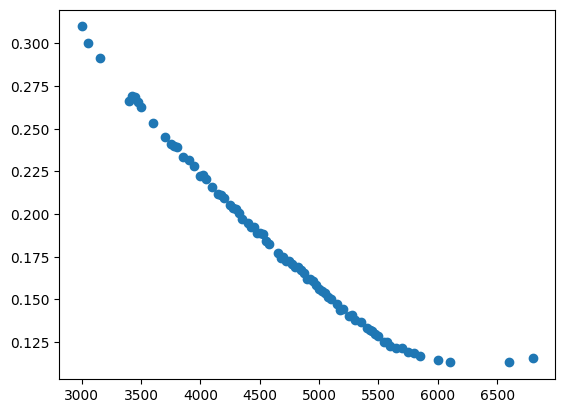

In [51]:
yf_sigma = list(latest_prices_df1['IVOL_LAST'])
#yf_sigma
strike_prices = list(latest_prices_df1['Strike'])
plt.plot(strike_prices, yf_sigma, 'o', label='iv')

strike_prices = np.array(strike_prices)
yf_sigma = np.array(yf_sigma)

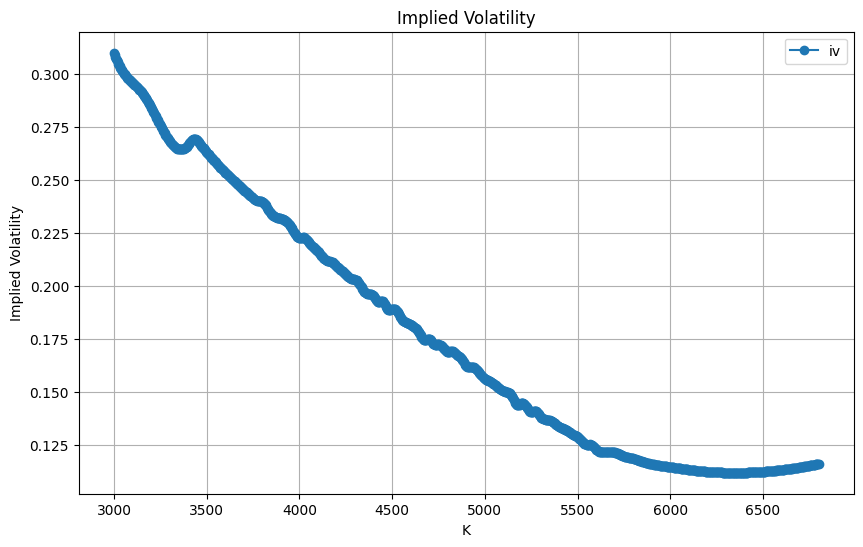

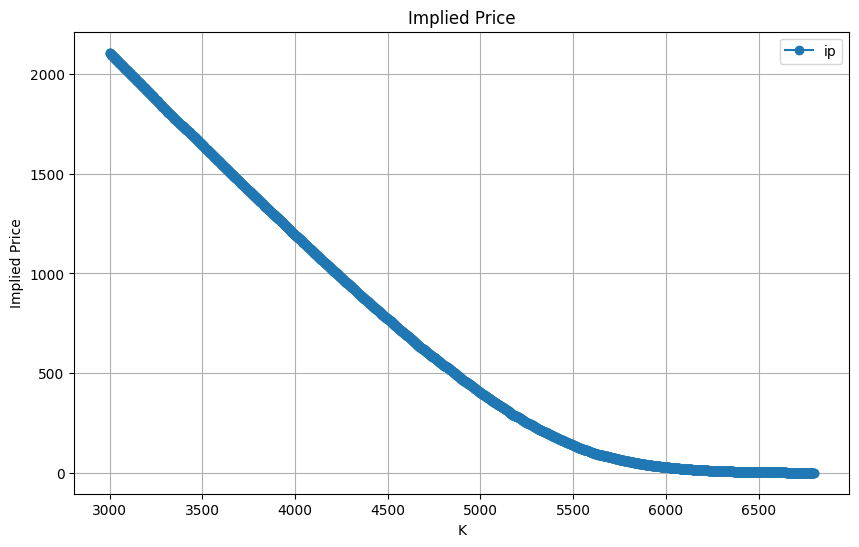

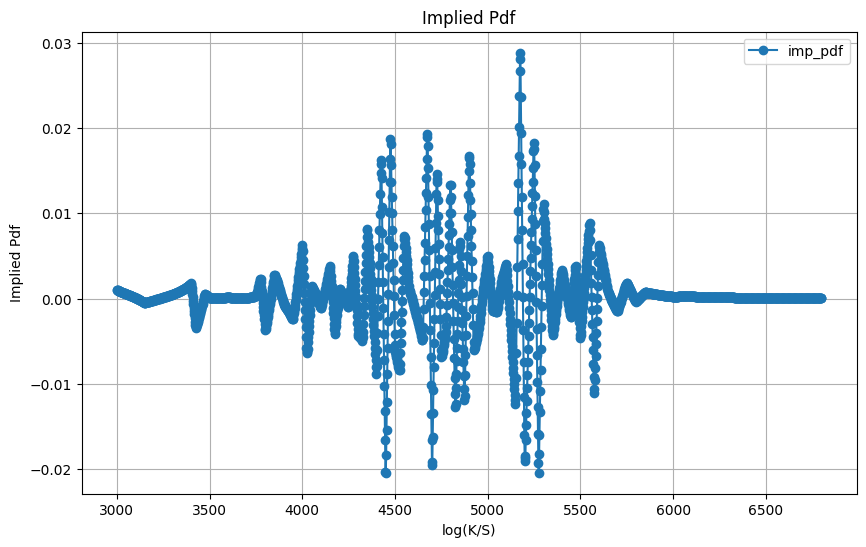

0

In [52]:
f1 = plot1(strike_prices, yf_sigma)
f2 = plot2(strike_prices, f1)
plot3(strike_prices, f2)

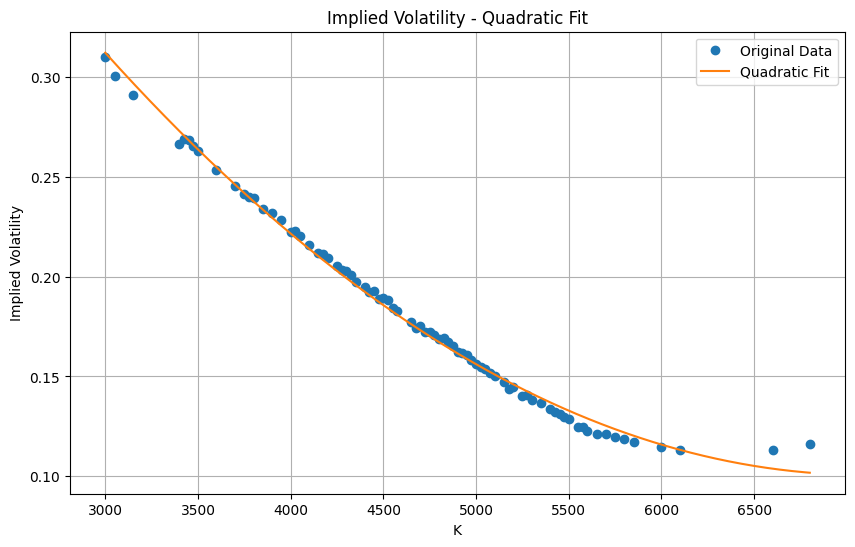

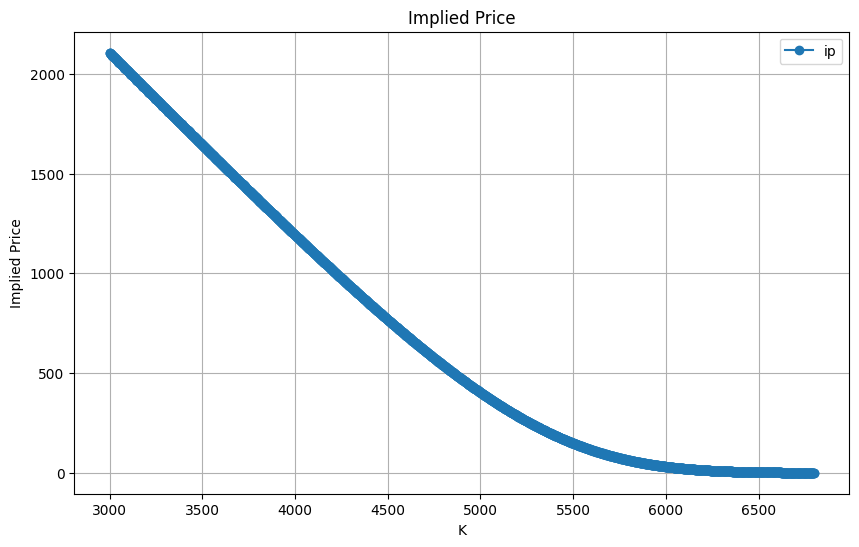

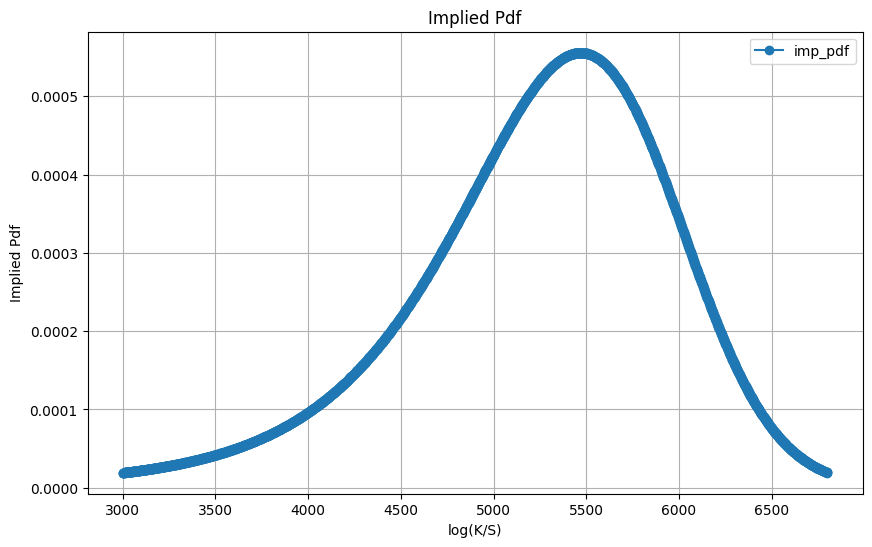

0

In [53]:
f1 = plot4(strike_prices, yf_sigma)
f2 = plot2(strike_prices, f1)
plot3(strike_prices, f2)

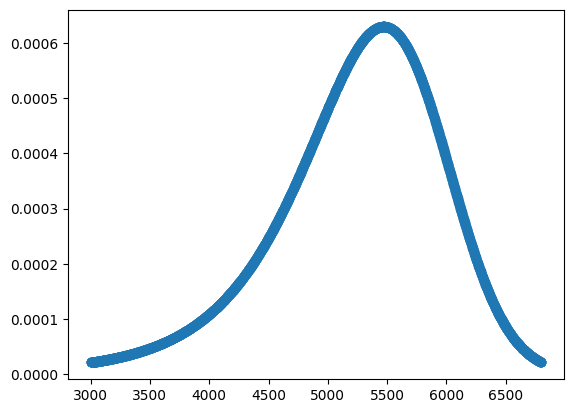

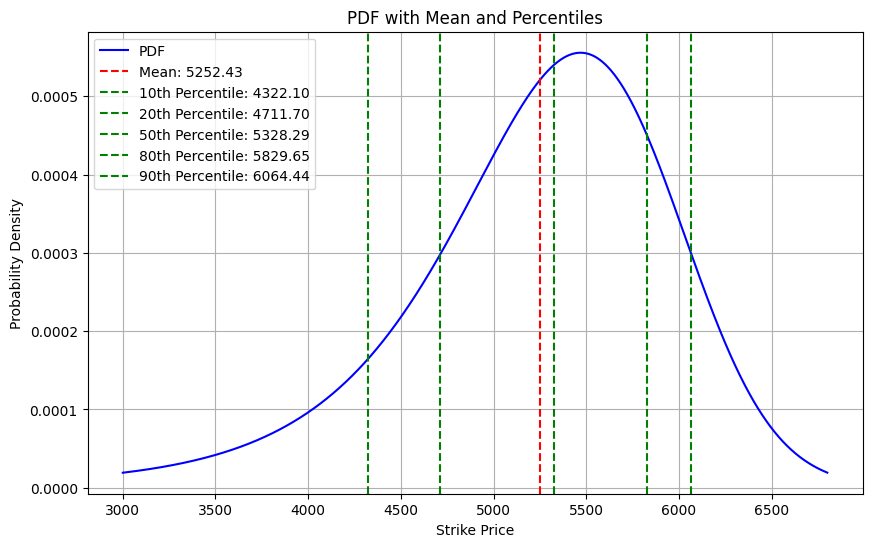

{'mean': 5252.431349595961,
 'variance': 467809.8896323287,
 'skewness': -3.815100284134303e-16,
 'kurtosis': 11.933670609972939,
 'percentiles': array([4322.10329087, 4711.69773572, 5328.28854845, 5829.64916748,
        6064.43714959])}

In [54]:
# descriptive statistics
calculate_statistics(f2.derivative(nu=2), r, T, IsPlot = 1)

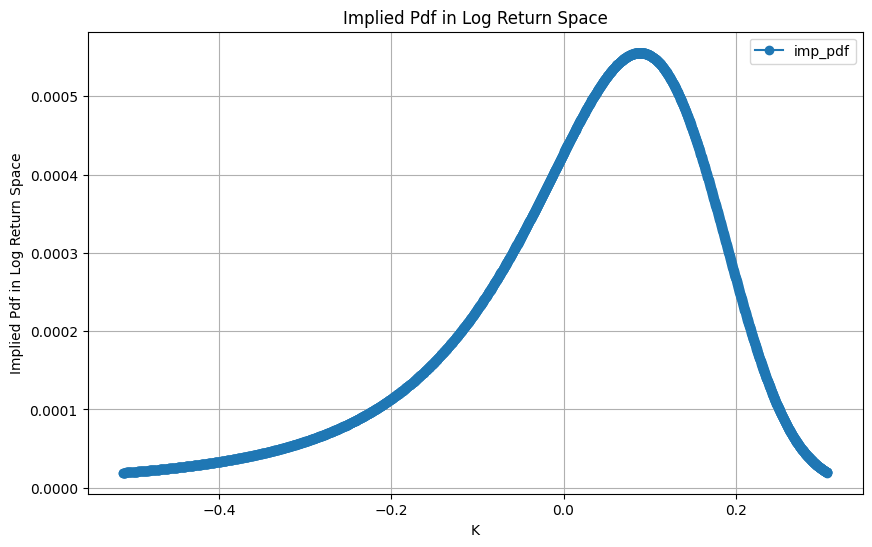

0

In [55]:
plot3_2(strike_prices, f2)

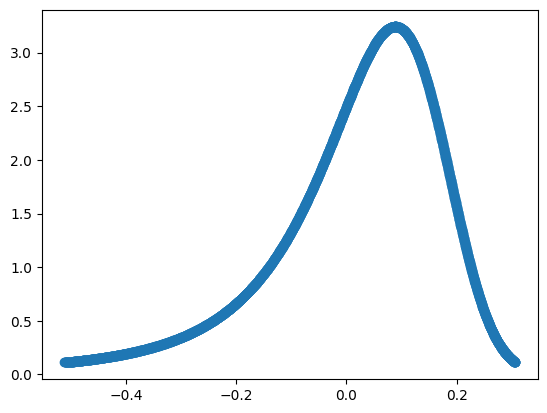

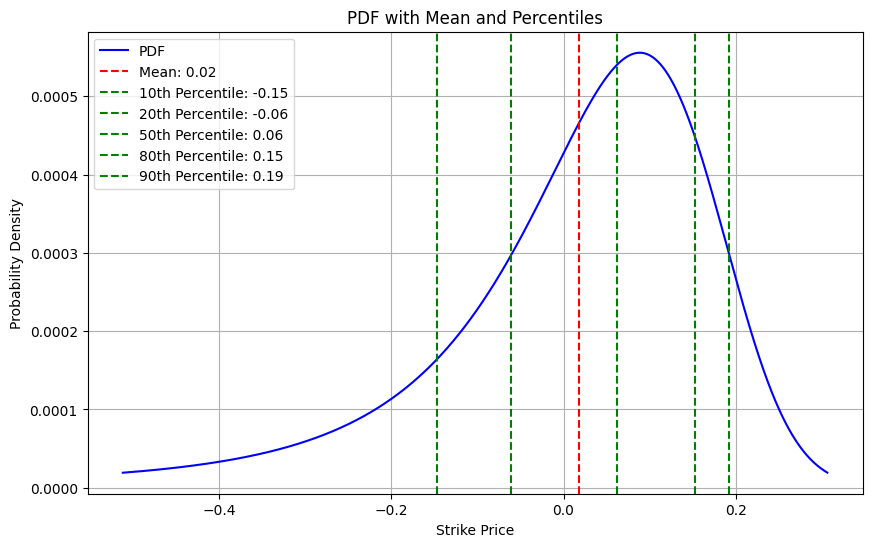

{'mean': 0.018328276529505368,
 'variance': 0.02210416225334163,
 'skewness': -1.0810311352324342,
 'kurtosis': 11.421178138008672,
 'percentiles': array([-0.14680916, -0.06050302,  0.06247879,  0.15240552,  0.19189044])}

In [56]:
# descriptive statistics
calculate_statistics(f2.derivative(nu=2), r, T, IsLog = 1, IsPlot = 1)

The prob of decreasing by 20% is 4.75%


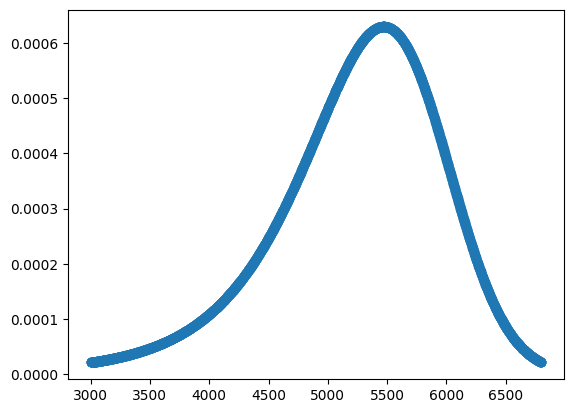

In [57]:
prob_dec = calculus(f2.derivative(nu=2), r, T, S*(1-0.2), IsLog = 0)
print("The prob of decreasing by 20% is {:.2f}%".format(prob_dec * 100))

The prob of increasing by 20% is 22.44%


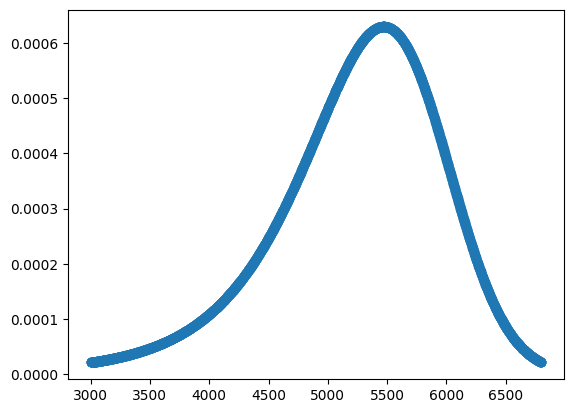

In [58]:
prob_inc = 1-calculus(f2.derivative(nu=2), r, T, S*(1+0.2), IsLog = 0)
print("The prob of increasing by 20% is {:.2f}%".format(prob_inc * 100))

In [68]:
def maincode(latest_prices):
  latest_prices_df1 = latest_prices.copy()
  latest_prices_df1 = latest_prices_df1[latest_prices_df1['IVOL_LAST']>0.001]
  latest_prices_df1['IVOL_LAST'] = latest_prices_df1['IVOL_LAST'] / 100
  latest_prices_df1.head()

  yf_sigma = list(latest_prices_df1['IVOL_LAST'])
  #yf_sigma
  strike_prices = list(latest_prices_df1['Strike'])
  plt.plot(strike_prices, yf_sigma, 'o', label='iv')
  strike_prices = np.array(strike_prices)
  yf_sigma = np.array(yf_sigma)

  f1 = plot4(strike_prices, yf_sigma)
  f2 = plot2(strike_prices, f1)
  plot3(strike_prices, f2)

  # descriptive statistics
  print(calculate_statistics(f2.derivative(nu=2), r, T, IsPlot = 1))

  prob_dec = calculus(f2.derivative(nu=2), r, T, S*(1-0.2), IsLog = 0)
  print("The prob of decreasing by 20% is {:.2f}%".format(prob_dec * 100))

  prob_inc = 1-calculus(f2.derivative(nu=2), r, T, S*(1+0.2), IsLog = 0)
  print("The prob of increasing by 20% is {:.2f}%".format(prob_inc * 100))

  return f2

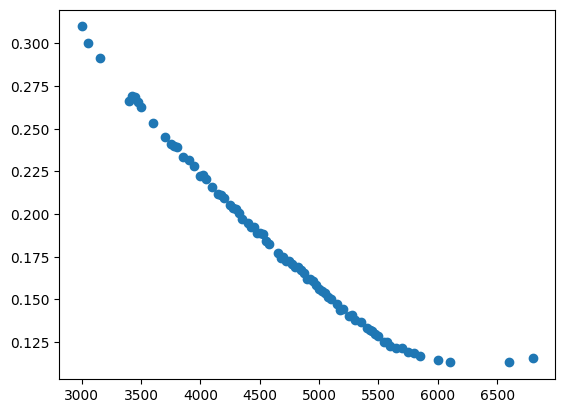

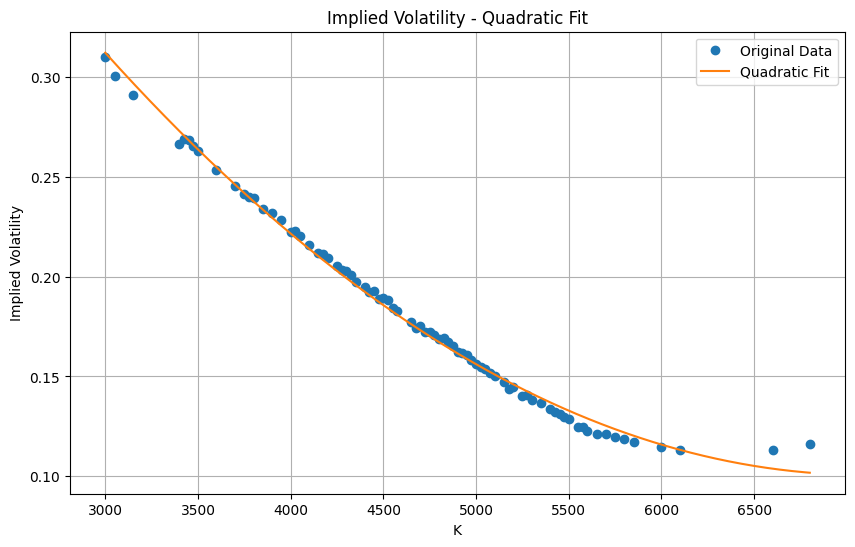

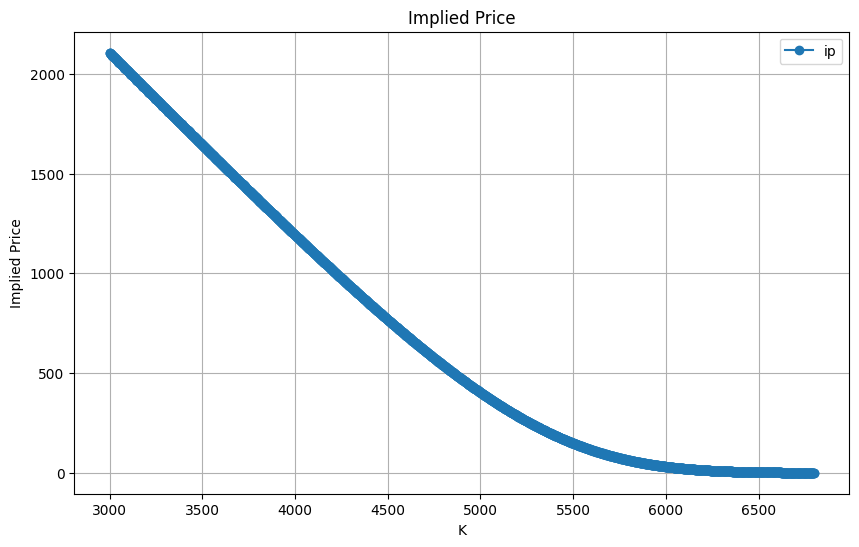

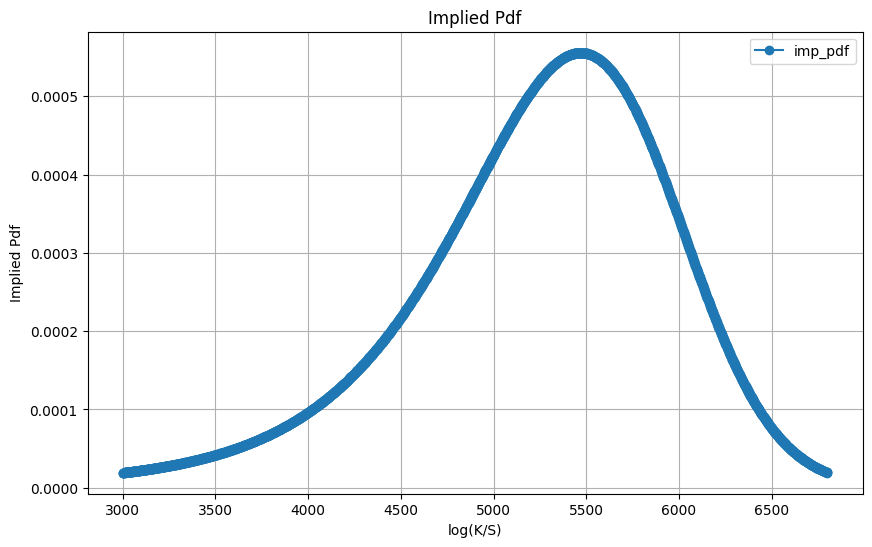

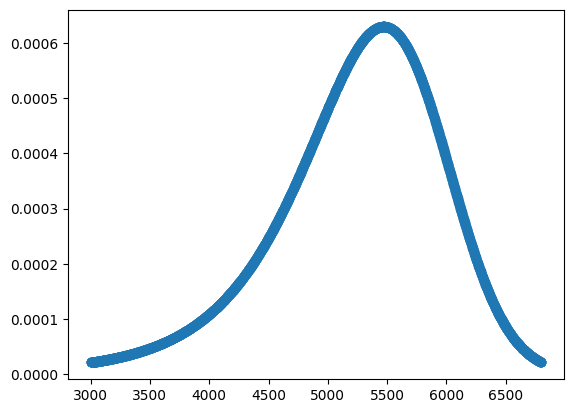

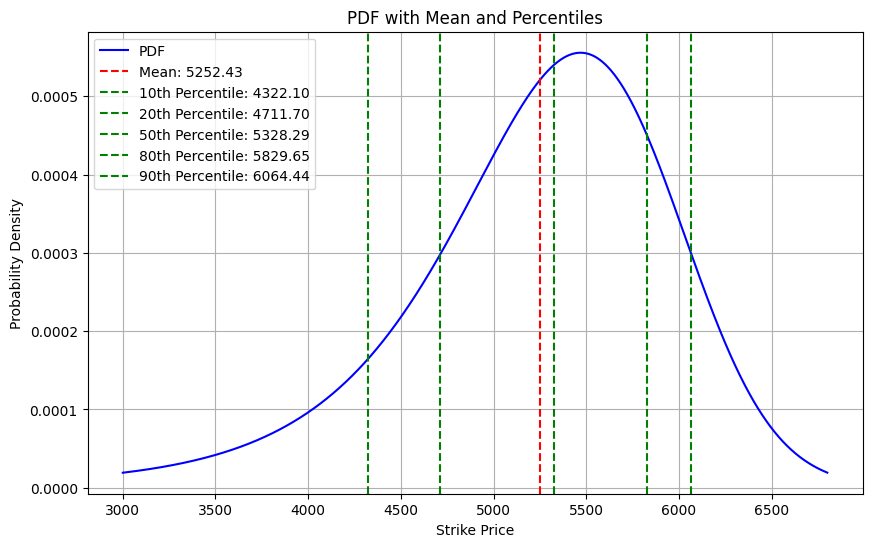

{'mean': 5252.431349595961, 'variance': 467809.8896323287, 'skewness': -3.815100284134303e-16, 'kurtosis': 11.933670609972939, 'percentiles': array([4322.10329087, 4711.69773572, 5328.28854845, 5829.64916748,
       6064.43714959])}
The prob of decreasing by 20% is 4.75%
The prob of increasing by 20% is 22.44%


0

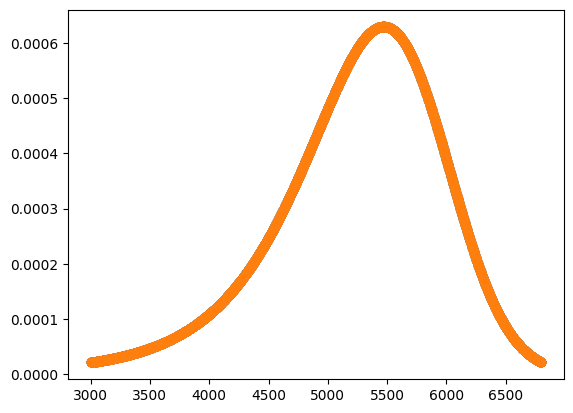

In [60]:
maincode(latest_prices)

one month ago:

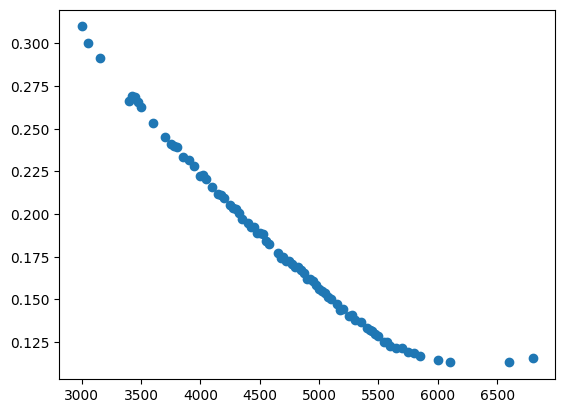

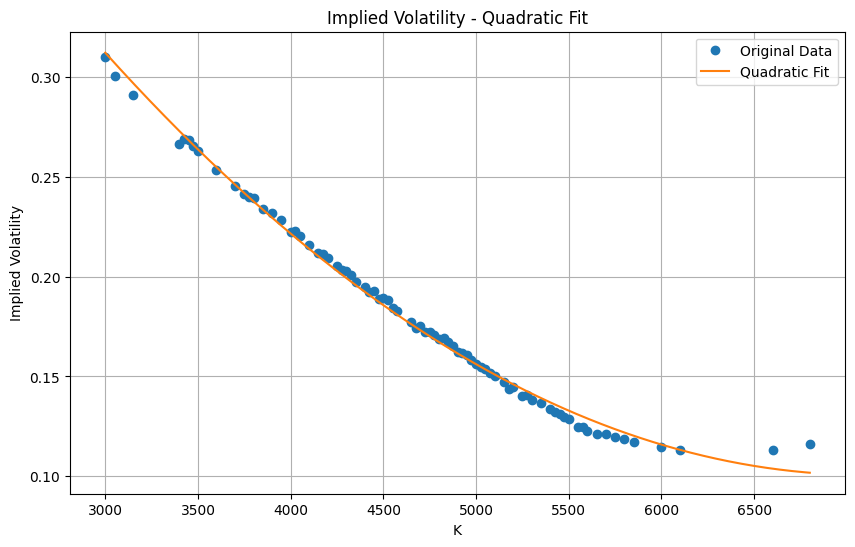

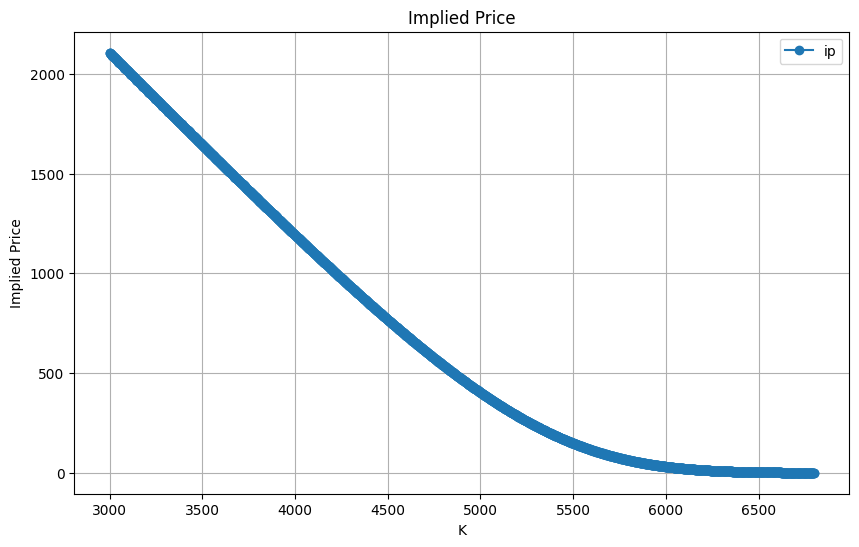

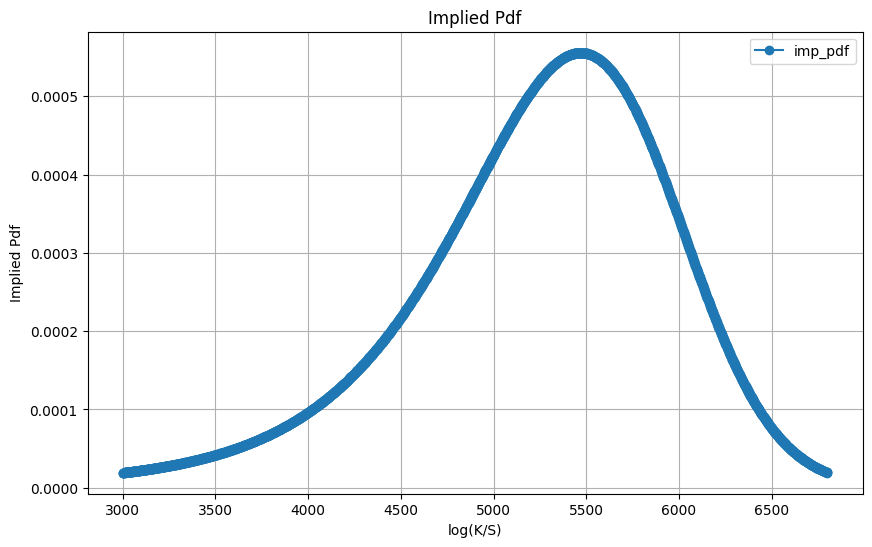

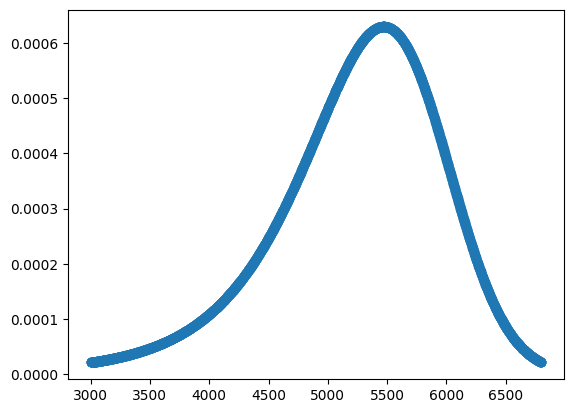

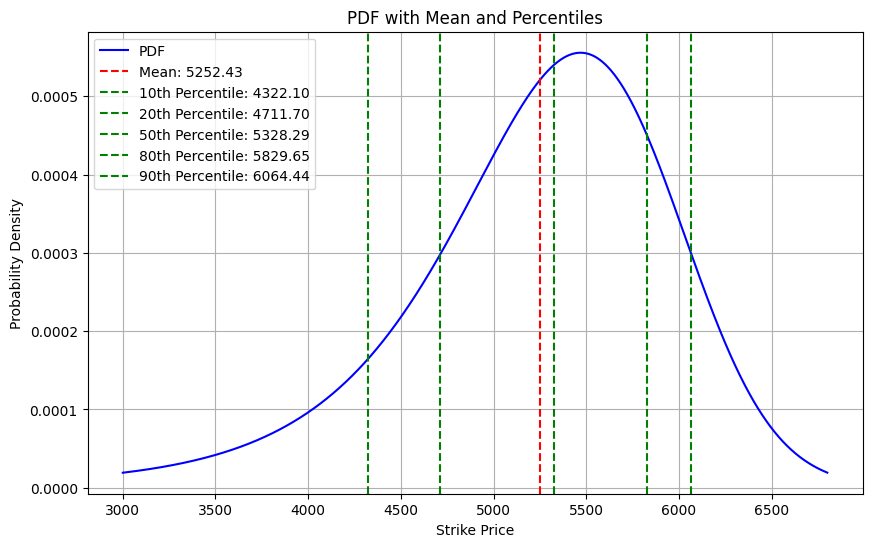

{'mean': 5252.431349595961, 'variance': 467809.8896323287, 'skewness': -3.815100284134303e-16, 'kurtosis': 11.933670609972939, 'percentiles': array([4322.10329087, 4711.69773572, 5328.28854845, 5829.64916748,
       6064.43714959])}
The prob of decreasing by 20% is 4.75%
The prob of increasing by 20% is 22.44%


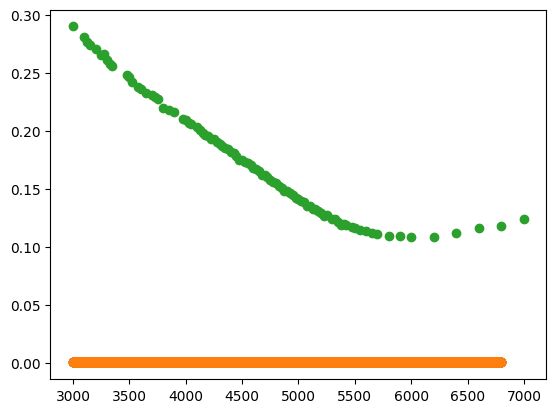

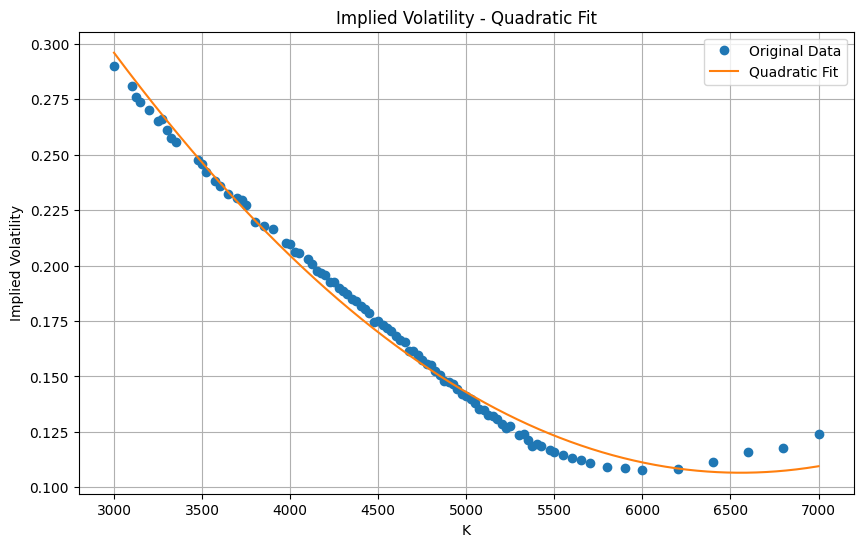

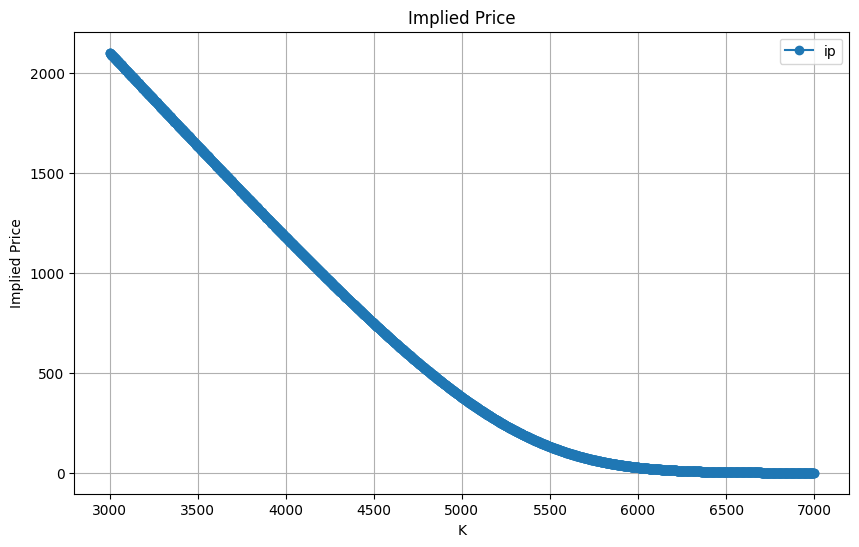

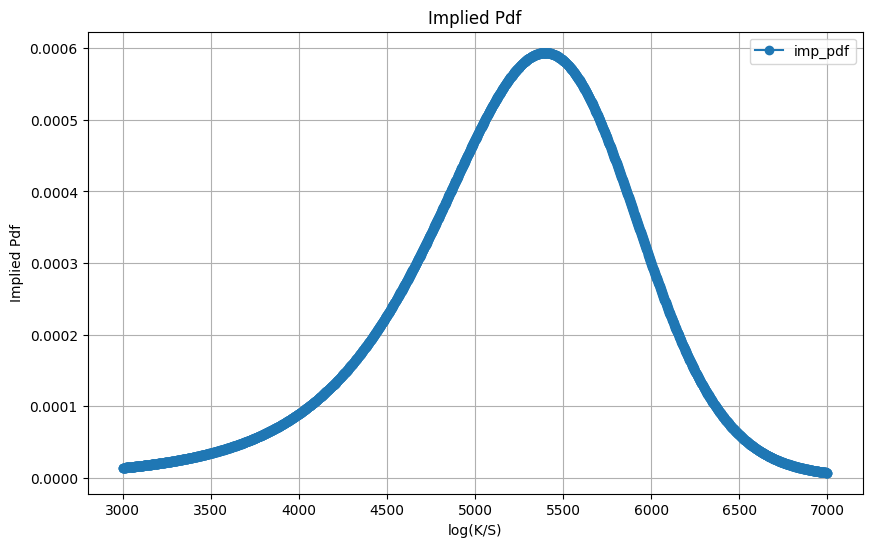

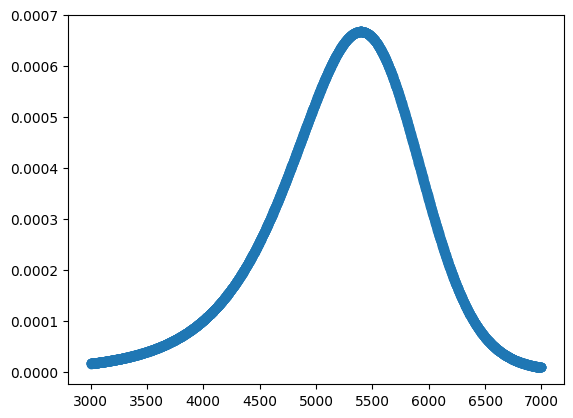

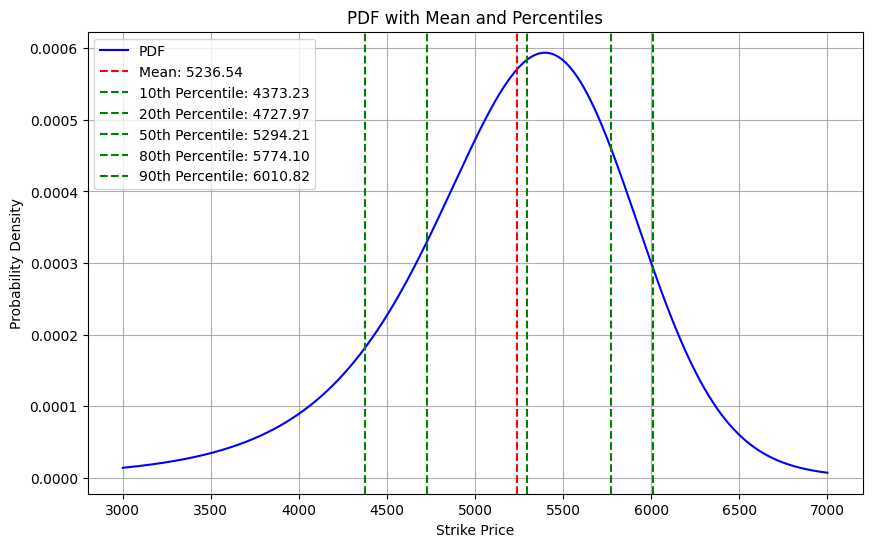

{'mean': 5236.543906565251, 'variance': 423704.8582900965, 'skewness': 2.655621286510699e-15, 'kurtosis': 17.86041455921087, 'percentiles': array([4373.22603184, 4727.97463404, 5294.20742166, 5774.10139833,
       6010.82022038])}
The prob of decreasing by 20% is 4.06%
The prob of increasing by 20% is 20.06%


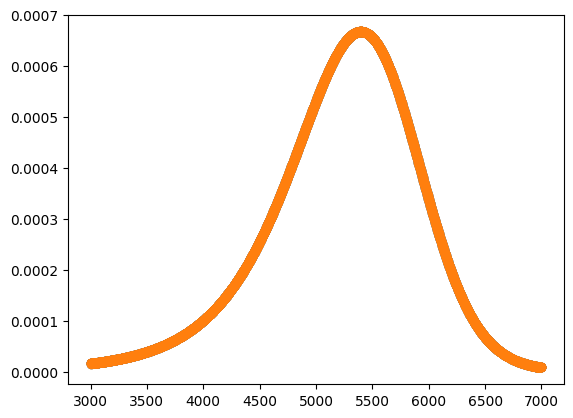

In [71]:
latest_prices = data_processing('Bloomberg option data without formula_v2.xlsx')
func_1 = maincode(latest_prices)

latest_prices_1m = data_processing('Bloomberg option data without formula_v3.xlsx')
func_2 = maincode(latest_prices_1m)



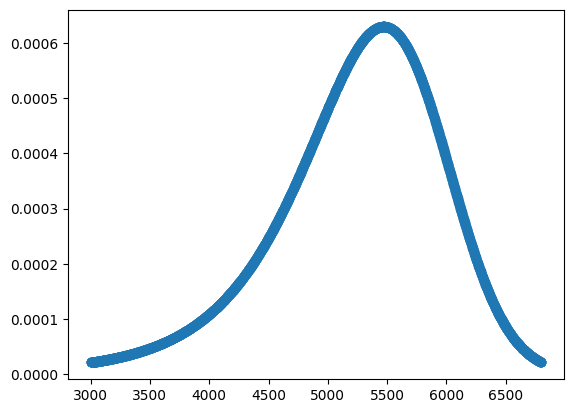

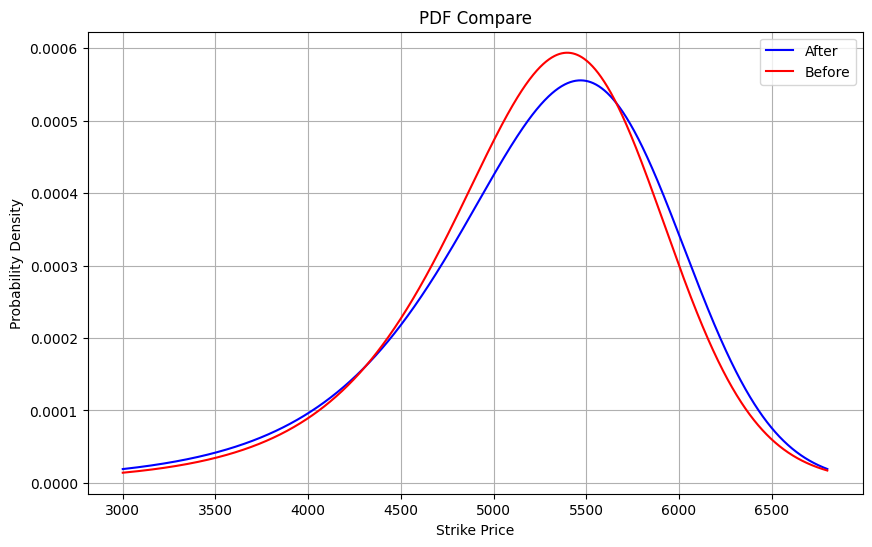

0

In [78]:
compare_pdf(func_1.derivative(nu=2), func_2.derivative(nu=2))

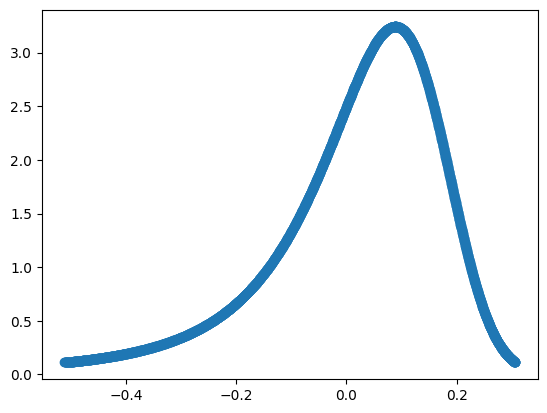

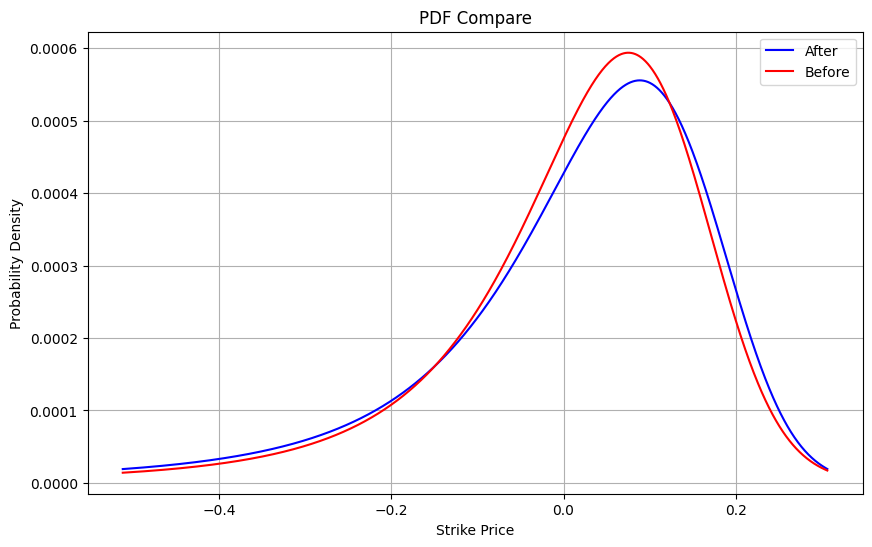

0

In [79]:
compare_pdf(func_1.derivative(nu=2), func_2.derivative(nu=2), IsLog = 1)

In [66]:
latest_prices_1m

,index,Ticker,Unnamed: 1,Date,Strike,PX_LAST,PX_BID,PX_ASK,IVOL_LAST,PX_VOLUME,Unnamed: 9,"PX_LAST, PX_BID, PX_ASK, IVOL_LAST, PX_VOLUME"
61,4,SPX US 01/17/25 P3000 INDEX,0,2024-01-16,3000,2107.437666,20.10,20.90,28.990,4.0,NaN,NaN
62,24,SPX US 01/17/25 P3100 INDEX,4,2024-01-16,3100,2015.047422,22.80,23.50,28.103,2.0,NaN,NaN
63,26,SPX US 01/17/25 P3125 INDEX,5,2024-01-10,3125,1992.074861,17.00,28.50,27.613,6.0,NaN,NaN
64,31,SPX US 01/17/25 P3150 INDEX,6,2024-01-10,3150,1969.0523,17.70,29.20,27.387,3.0,NaN,NaN
65,40,SPX US 01/17/25 P3200 INDEX,8,2024-01-09,3200,1923.657178,26.00,26.80,27.033,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
56,641,SPX US 01/17/25 C6200 INDEX,128,2024-01-10,6200,5.18,0.55,10.20,10.809,3.0,NaN,NaN
57,683,SPX US 01/17/25 C6400 INDEX,136,2024-01-12,6400,2.8,2.40,3.20,11.130,4.0,NaN,NaN
58,724,SPX US 01/17/25 C6600 INDEX,144,2024-01-16,6600,1.55,1.25,1.95,11.611,1300.0,NaN,NaN
59,761,SPX US 01/17/25 C6800 INDEX,152,2024-01-10,6800,1,0.10,2.20,11.762,1.0,NaN,NaN


In [67]:
latest_prices

,index,Ticker,Unnamed: 1,Date,Strike,PX_LAST,PX_BID,PX_ASK,IVOL_LAST,PX_VOLUME,Unnamed: 9,"PX_LAST, PX_BID, PX_ASK, IVOL_LAST, PX_VOLUME"
53,4,SPX US 02/21/25 P3000 INDEX,0,2024-02-16,3000,2106.837666,17.1,20.5,30.987,1.0,NaN,NaN
54,10,SPX US 02/21/25 P3050 INDEX,2,2024-02-12,3050,2058.842544,NaN,NaN,30.047,1.0,NaN,NaN
55,30,SPX US 02/21/25 P3150 INDEX,6,2024-02-12,3150,1966.0023,NaN,NaN,29.115,1.0,NaN,NaN
0,84,SPX US 02/21/25 C3400 INDEX,16,2024-02-16,3400,1780.64,1734.1,1759.8,26.635,1.0,NaN,NaN
56,88,SPX US 02/21/25 P3425 INDEX,17,2024-02-15,3425,1714.304128,28.7,31.5,26.906,10.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
48,604,SPX US 02/21/25 C6000 INDEX,120,2024-02-16,6000,36.63,28.7,41.4,11.442,1.0,NaN,NaN
49,624,SPX US 02/21/25 C6100 INDEX,124,2024-02-16,6100,26.38,23.1,26.8,11.315,1.0,NaN,NaN
50,683,SPX US 02/21/25 C6400 INDEX,136,2024-02-15,6400,10.32,9.1,11.9,NaN,1.0,NaN,NaN
51,723,SPX US 02/21/25 C6600 INDEX,144,2024-02-15,6600,5.59,4.3,7.0,11.306,2.0,NaN,NaN
